# Grover Adaptive Search Big Test

This Python notebook provides a big test of Grover Adaptive search with a bigger example, separated from the `GAS_Tester.ipynb` notebook. All tests have been executed on the **OpenQASM Simulator** (https://sooluthomas.github.io/testTranslation/terra/executing_quantum_programs.html#executing-quantum-programs) offered by Qiskit, but any other backend (simulator or real quantum machine) can be used to run these tests.

In [10]:
from qiskit import *
from qiskit.visualization import plot_histogram

from random import getrandbits, randint, random

from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.patches import Ellipse

import numpy as np

from binary_cost_function import *
from custom_gas import *
from num_base_converter import *

from functools import reduce

We will perform a bigger test of GAS to showcase a longer execution of the algorithm. We first create a randomized binary cost function. The following parameters control the nature of the cost function:
  - `num_bits`: Number of bits of the clauses
  - `spec`: Percentage of clause bits on $\mathtt{0}$ or $\mathtt{1}$
  - `v_min, v_max`: Random range of values of the clauses
  - `c_min, c_max`: Random range of number of clauses

In [4]:
num_bits = 8
spec = 0.45
v_min, v_max = -5, 5
c_min, c_max = 16, 16

In [5]:
bcf = generate_random_bcf(num_bits, spec, v_min, v_max, c_min, c_max)
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, bcf.get_values())) + 1, -sum(filter(lambda x: x<0, bcf.get_values()))]), 2)) + 2

print("n = ", n, ", m = ", m, sep = "")
print("bcf: ")
print(bcf)

n = 8, m = 8
bcf: 
3 * 01X1XX0X
5 * 1XX11X1X
-5 * X0XXXXX1
3 * 010XX01X
4 * 0X0XX0XX
-1 * X11XX1X0
3 * 0XXXXXX1
3 * 10X0XXX1
4 * XXX1X1XX
-3 * 1X1X11X0
4 * X11XXXX1
-4 * XXXXXX00
-3 * XX1XX0XX
-4 * XXXXX0X1
3 * 1XX10011
-4 * 0111X0XX



This time, we will not reset the number of $G$ applications $r$ back to $1$ when finding a better string. Instead, every time we find a better string, we will leave $r$ untouched and run Grover Search again with the updated threshold. The stop condition will be the same: Stop when running Grover Search with $r = r_{max}$ does not output a better string.

In [6]:
def GAS_run(n, m, bcf, verbose = False):    
    #Precalculate r_max
    r_max = math.floor(math.pi/(4*math.asin(2**(-n/2))))

    #Best strings and values: First are chosen randomly
    best_strs = [dec_to_bin(getrandbits(n), n)]
    best_vals = [bcf.evaluate(best_strs[-1])]
    read_strs = [best_strs[-1]]
    read_vals = [best_vals[-1]]
    r_appls = []

    if verbose:
        print(("Initial conditions: x={0:s}, y={1:" + str(n) + "d}").format(best_strs[-1], best_vals[-1]))
        print("Iterations until r = r_max = {0:d}\n".format(r_max))

    r = 1
    num_iters = 1
    while r <= r_max:
        r_appls.append(r)
        if verbose: print(("Iteration {0:" + str(n) + "d}: r={1:2d}").format(num_iters, r), end = "")

        #Create and run GAS quantum circuit
        # Threshold: Last best value
        qc = QuantumCircuit()
    
        qr_strs = QuantumRegister(n, "strs")
        qr_vals = QuantumRegister(m, "vals")
        qc.add_register(qr_strs)
        qc.add_register(qr_vals)
        
        cr_strs = ClassicalRegister(n, "cl_strs")
        cr_vals = ClassicalRegister(m, "cl_vals")
        qc.add_register(cr_strs)
        qc.add_register(cr_vals)
    
        qc.append(GAS_circuit(m, bcf, best_vals[-1], r).to_gate(), qr_strs[:] + qr_vals[:])
        qc.measure(qr_strs, cr_strs)
        qc.measure(qr_vals, cr_vals)
        
        job = execute(qc, Aer.get_backend("qasm_simulator"), shots = 1)
        counts = job.result().get_counts()
        
        #Retrieve read_str and read_val
        results = list(counts.keys())[0].split(" ")
        read_str = results[1]
        read_val_bin = results[0]
        read_val = bin_ca2_to_dec(results[0])
        read_corr_val = read_val + best_vals[-1]
        read_strs.append(read_str)
        read_vals.append(read_val + best_vals[-1])

        if verbose: print((" x={0:s}, y={1:s} y_val={2:" + str(n) + "d}").format(read_str, read_val_bin, read_corr_val), end = "")

        #If read_corr_val is better (smaller) than best_vals[-1]: Update threshold and reset r to 1
        #If not: Do not update threshold, increase r by 1
        if read_corr_val < best_vals[-1]:
            best_strs.append(read_str)
            best_vals.append(read_corr_val)
            #r = 1
            if verbose: print(" !! ", end = "")
        else:
            best_strs.append(best_strs[-1])
            best_vals.append(best_vals[-1])
            r += 1
            if verbose: print("    ", end = "")

        if verbose: print((" best_str={0:s}, best_val={1:" + str(n) + "d})").format(best_strs[-1], best_vals[-1]))
    
        #Update number of iterations
        num_iters += 1
    
    return best_strs, best_vals, read_strs, read_vals, r_appls

Execute the next cell to run the test. <span style="color:red">**Warning:**</span> The tests may take a few minutes to complete.

Initial conditions: x=01011010, y=       7
Iterations until r = r_max = 12

Iteration        1: r= 1 x=01000010, y=00000000 y_val=       7     best_str=01011010, best_val=       7)
Iteration        2: r= 2 x=11111101, y=00000001 y_val=       8     best_str=01011010, best_val=       7)
Iteration        3: r= 3 x=11000010, y=11111001 y_val=       0 !!  best_str=11000010, best_val=       0)
Iteration        4: r= 3 x=00111110, y=00000100 y_val=       4     best_str=11000010, best_val=       0)
Iteration        5: r= 4 x=11010001, y=11111100 y_val=      -4 !!  best_str=11010001, best_val=      -4)
Iteration        6: r= 4 x=11000011, y=00000000 y_val=      -4     best_str=11010001, best_val=      -4)
Iteration        7: r= 5 x=10111000, y=11111101 y_val=      -7 !!  best_str=10111000, best_val=      -7)
Iteration        8: r= 5 x=00001000, y=00000111 y_val=       0     best_str=10111000, best_val=      -7)
Iteration        9: r= 6 x=01110010, y=00000000 y_val=      -7     best_str=10111000

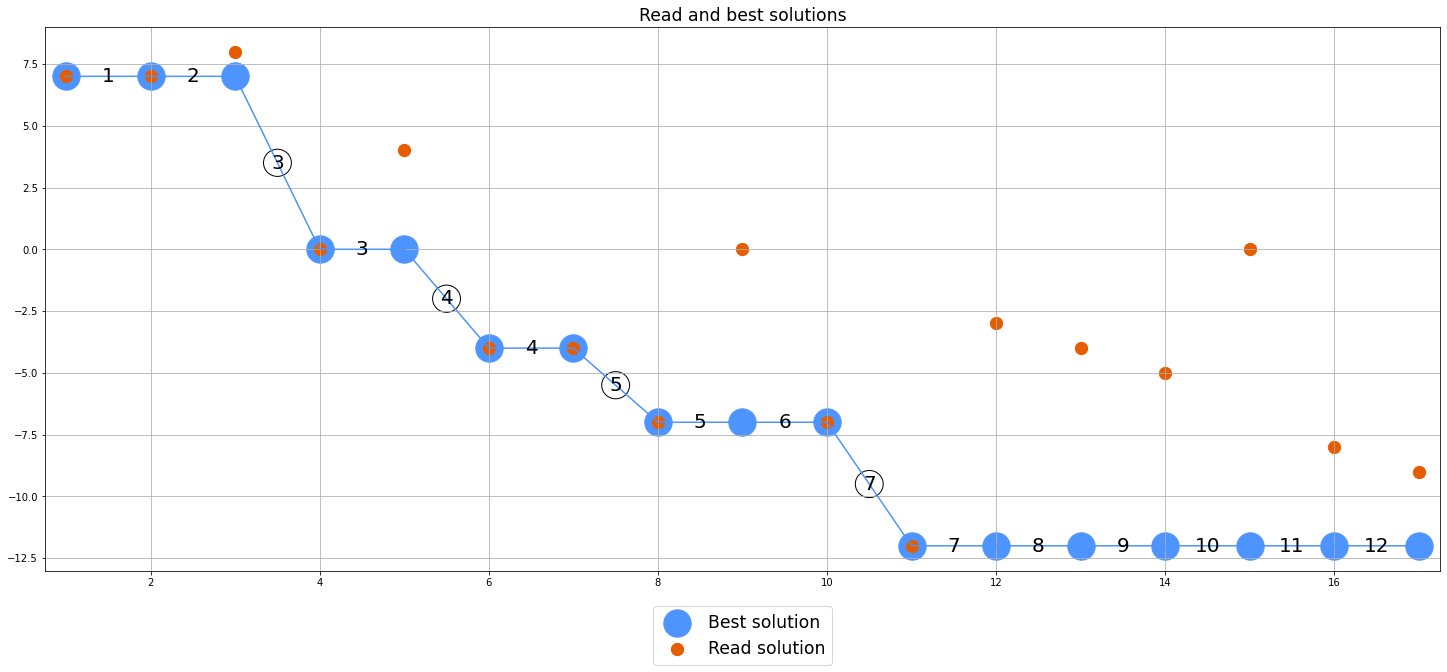

In [7]:
best_strs, best_vals, read_strs, read_vals, r_appls = GAS_run(n, m, bcf, verbose = True)

width, height = 25, 10
fig = plt.figure(figsize=(width, height))
ax = plt.subplot(1, 1, 1)
num_data = len(best_vals)
min_y, max_y = min(read_vals), max(read_vals)
x = np.arange(1, num_data+1)
ax.set_xlim(0.75, num_data + 0.25)
ax.set_ylim(min_y - 1, max_y + 1)
ax.plot(x, best_vals, color = "#4d94ff")
ax.scatter(x, best_vals, s = 750, color = "#4d94ff", label = "Best solution")
ax.scatter(x, read_vals, s = 150, color = "#e65c00", label = "Read solution")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize = "xx-large")
ax.set_title("Read and best solutions", fontsize = "xx-large")
ax.grid()
d = 0
w = width / (num_data - 0.5)
h = height / (max_y - min_y + 2)
r = 0.5
for i in range(num_data - 1):
    y1, y2 = best_vals[i], best_vals[i+1]
    if y1 != y2:
        ax.add_patch(Ellipse(
            (i + 1.5, ((y1 + y2) / 2)),
            width = r / w,
            height = r / h,
            color = "black",
            fill = False,
            linewidth = 1
        ))
    ax.text(
        i + 1.5,
        ((y1 + y2) / 2),
        str(r_appls[i]),
        verticalalignment = "center",
        horizontalalignment = "center",
        fontsize = 20
    )
plt.show()

And finally, to make sure the algorithm succeeded, we exhaustively evaluate the binary cost function and compare with the algorithm's output.

In [12]:
best_str, best_val = bcf.min_exhaustively()
print("Expected string: {0:s}".format(best_str))
print("Returned string: {0:s}".format(best_strs[-1]))
print("Expected value: {0:d}".format(best_val))
print("Returned value: {0:d}".format(best_vals[-1]))
print("Total G applications: {0:d}".format(sum(r_appls)))

AttributeError: 'BinaryCostFunction' object has no attribute 'min_exhaustively'

The tests can be performed with any binary cost function, as the number of qubits, maximum rotations, and other parameters are set automatically for any chosen binary cost function.

One should note, though, that simulation times scale exponentially with the number of qubits, meaning that the more complex the cost function, the much longer simulations will take to complete. Also, one should note that Qiskit's **OpenQASM Simulator**  has a hard cap of 30 qubits for simulations.